### NER (NAME ENTITY RECOGNITION)

#cOnll 2003
#XTREME
#crossNER

In [3]:
import pandas as pd

tokens = "Sandeep Reddy is a computer scientist at Google Aravind facebook Snapchat in Texas".split()
labels = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "B-PER","B-ORG", "I-ORG", "O", "B-LOC"]

df = pd.DataFrame(data=[tokens, labels], index=['tokens', 'labels'])
df


,0,1,2,3,4,5,6,7,8,9,10,11,12
tokens,Sandeep,Reddy,is,a,computer,scientist,at,Google,Aravind,facebook,Snapchat,in,Texas
labels,B-PER,I-PER,O,O,O,O,O,B-ORG,B-PER,B-ORG,I-ORG,O,B-LOC


## Dataset
**Cross-lingual TRansfer Evaluation of Multilingual Encoders (XTREME)**

In [4]:
from datasets import get_dataset_config_names
from datasets import load_dataset

xtreme_subsets = get_dataset_config_names("xtreme")

c:\Users\reddy\anaconda3\envs\project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [6]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [7]:
len(panx_subsets)

40

In [8]:
load_dataset("xtreme", name="PAN-X.en")

Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 1142581.93 examples/s]


DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [9]:
## Load inside a variable
en = load_dataset("xtreme", name='PAN-X.en')

In [10]:
en.keys()

dict_keys(['train', 'validation', 'test'])

In [21]:
en_train = en['train']

In [12]:
en_train

Dataset({
    features: ['tokens', 'ner_tags', 'langs'],
    num_rows: 20000
})

In [13]:
en_train[42]

{'tokens': ['File', ':', 'CCStaClara.JPG|Through', 'Santa', 'Clara'],
 'ner_tags': [0, 0, 0, 5, 6],
 'langs': ['en', 'en', 'en', 'en', 'en']}

### Create a dictionary

In [27]:
pd.DataFrame(en["train"][0]).transpose()

,0,1,2,3,4,5,6,7,8,9,10
tokens,R.H.,Saunders,(,St.,Lawrence,River,),(,968,MW,)
ner_tags,3,4,0,3,4,4,0,0,0,0,0
langs,en,en,en,en,en,en,en,en,en,en,en


In [15]:
for key, value in en["train"].features.items():
    print(f"{key}: {value} \n")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None) 

ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None) 

langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None) 



In [16]:
tags = en["train"].features["ner_tags"].feature
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_en = en.map(create_tag_names)
de_example = panx_en["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
['Tokens', 'Tags'])

Map: 100%|██████████| 10000/10000 [00:00<00:00, 31148.91 examples/s]


,0,1,2,3,4,5,6,7,8,9,10
Tokens,R.H.,Saunders,(,St.,Lawrence,River,),(,968,MW,)
Tags,B-ORG,I-ORG,O,B-ORG,I-ORG,I-ORG,O,O,O,O,O


In [17]:
from collections import Counter
from collections import defaultdict
from datasets import DatasetDict
split2freqs = defaultdict(Counter)
for split, dataset in panx_en.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,ORG,PER,LOC
train,9422,9164,9345
validation,4677,4635,4834
test,4745,4556,4657


### Model we would be using 

In [18]:
## XLM-Roberta model
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [19]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [20]:
df = pd.DataFrame([bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])
df

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


## SentencePiece Tokenizer

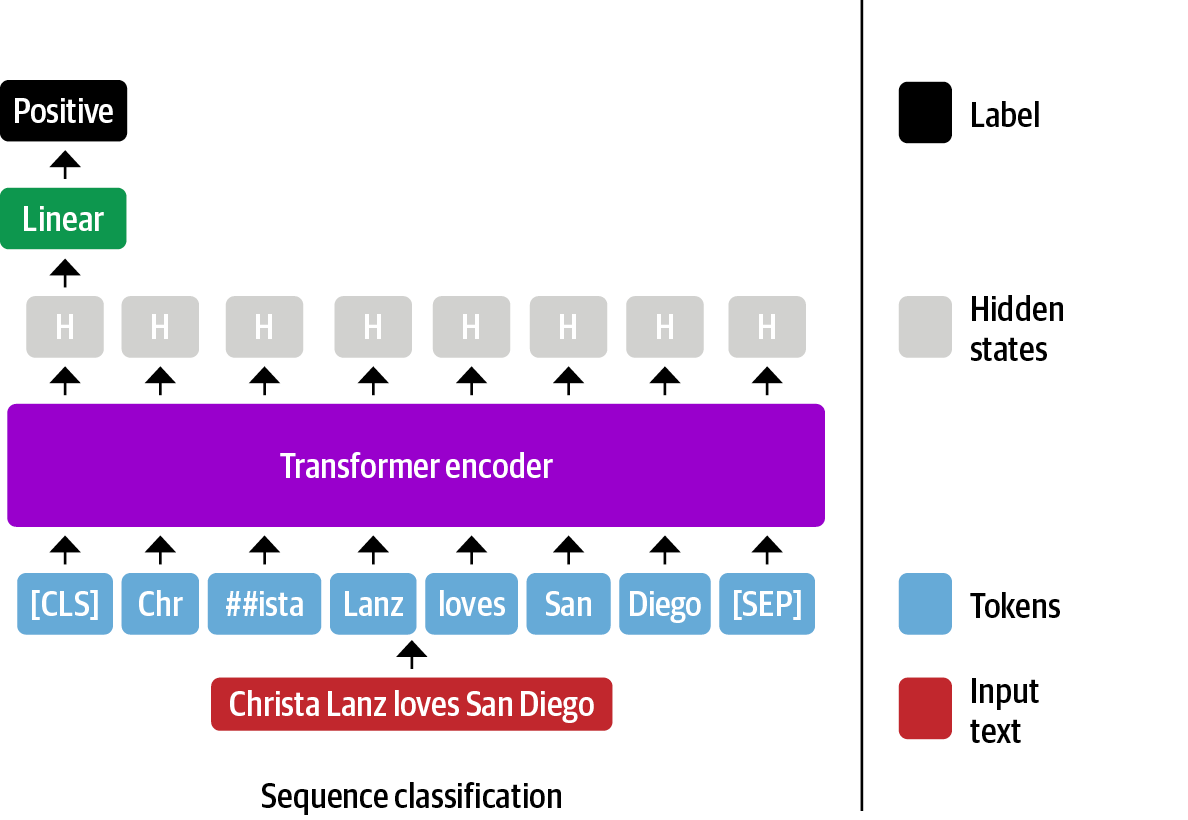
